### Setup for colab

In [ ]:
# For colab only
!git clone https://github.com/Hollfelder-Lab/lrDMS-IRED.git
!pip install -e ./lrDMS-IRED

In [1]:
%load_ext autoreload
%autoreload 2

# 1. Setup

### 1.1 General imports for all experiments

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

# General imports for all experiments
from lrdms.constants import DATA_PATH
from lrdms.data.srired import IRED
from lrdms.utils.mutations import Variant, count_possible_mutations

### 1.2 Load experimental data

In [3]:
# Load and pre-process the data
srired = IRED()
srired

# Single mutant statistics
_n_singles_observed = len(srired.data.query("hamming_to_wildtype == 1"))
_n_singles_possible = count_possible_mutations(srired.sequence_length, 1)
print(
    f"Observed single mutants: {_n_singles_observed} / {_n_singles_possible} possible ({_n_singles_observed / _n_singles_possible:.2%})"
)

2024-05-29 02:04:54.473 | INFO     | lrdms.data.srired:_process_raw_data:44 - Remove 0 NaN sequences
2024-05-29 02:04:54.474 | INFO     | lrdms.data.srired:_process_raw_data:48 - Remove 0 NaN fitness values
2024-05-29 02:04:54.477 | INFO     | lrdms.data.srired:_process_raw_data:53 - Remove 1320 sequences not ending in stop
2024-05-29 02:04:54.485 | INFO     | lrdms.data.srired:_process_raw_data:59 - Remove 981 sequences with intermediate stop
2024-05-29 02:04:54.504 | INFO     | lrdms.data.srired:_process_raw_data:70 - Remove 0 sequences with non-standard AAs
2024-05-29 02:04:54.507 | INFO     | lrdms.data.srired:_process_raw_data:75 - Remove 15 sequences with length != 290
2024-05-29 02:04:54.511 | INFO     | lrdms.data.srired:_process_raw_data:81 - Remove 3 sequences with >15 mutations
2024-05-29 02:04:54.513 | INFO     | lrdms.data.srired:_process_raw_data:93 - Parsing variants from sequences
2024-05-29 02:04:54.643 | INFO     | lrdms.data.srired:_process_raw_data:98 - Evaluating r

Observed single mutants: 1207 / 5510 possible (21.91%)


### 1.3 Load tranception & ESM prediction data for singles

Load `Tranception` language model predictions

In [4]:
# Load tranception data
tranception_results = pd.read_csv(
    DATA_PATH / "srired_tranception_predictions_plm_only.csv"
)  # TODO: Rename & create code to generate this file
tranception_results["variant"] = tranception_results.mutated_sequence.apply(
    lambda x: str(Variant.from_mutated_seq(x, srired.wildtype_seq))
)

# Map corresponding values based on `variant` to srired.data via a dataframe join
srired.data = srired.data.merge(tranception_results[["variant", "avg_score"]], on="variant", how="left")
srired.data = srired.data.assign(avg_score=srired.data.avg_score.fillna(0))
srired.data.rename(columns={"avg_score": "tranception_log_density"}, inplace=True)

Load `ESM` language model predictions

In [5]:
# Load ESM data
esm_singles = pd.read_csv(
    DATA_PATH / "srired_esm2_predictions_single_mutants.csv", index_col=0
)  # TODO: Rename & create code to generate this file
esm_singles.rename(columns={"fitness": "esm_log_density"}, inplace=True)
srired.data = srired.data.merge(esm_singles[["variant", "esm_log_density"]], on="variant", how="left")

### 1.3 Set up singles predictions

In [6]:
from lrdms.data.predictions import VariantPredictions
from lrdms.utils.mutations import generate_single_mutants

# Set up singles data
singles = VariantPredictions.from_variants(srired, generate_single_mutants(srired.wildtype_seq))
singles.data["seq"] = singles.data.variant.apply(lambda x: Variant.from_str(x).get_sequence(srired.wildtype_seq))

# Match ESM singles predictions
singles.data = singles.data.merge(
    esm_singles.rename(columns=dict(esm_log_density="fitness_esm")), left_on="variant", right_on="variant"
)

# 2. Singles evaluation

## 2.1 Final prediction

In [7]:
from lrdms.model.single_mutations import JointPredictor, AAIndexPredictor, LookUpPredictor

train, test = "hamming_to_wildtype == 1", "hamming_to_wildtype == 1"

model = JointPredictor(
    predictors=[
        AAIndexPredictor(reg_coef=1.0, n_components=19, seed=7),
        LookUpPredictor(singles.data.set_index("seq")["fitness_esm"].to_dict(), reg_coef=1e-6),
    ],
    reg_coef=1.0,
)
model.fit(
    srired.data.query(train)["sequence"].values,
    srired.data.query(train)["fitness"].values,
)
y_pred = model.predict(srired.data.query(test)["sequence"].values)
y_true = srired.data.query(test)["fitness"].values

singles.data["fitness_lr_combo"] = model.predict(
    singles.data.variant.apply(lambda x: Variant.from_str(x).get_sequence(singles.wildtype_seq))
)

/Users/simon/code/lrDMS-IRED/src/lrdms/model/single_mutations.py:11: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [8]:
print("Final single-mutant predictions (top 10):")
singles.data.sort_values(by="fitness_lr_combo", ascending=False).query("not observed").head(10)

Final single-mutant predictions (top 10):


,variant,observed,hamming_to_wildtype,seq,fitness_esm,fitness_lr_combo
3843,P203G,False,1,MRDTDVTVLGLGLMGQALAGAFLKDGHATTVWNRSEGKAGQLAEQG...,-4.704839,1.667147
4565,T241G,False,1,MRDTDVTVLGLGLMGQALAGAFLKDGHATTVWNRSEGKAGQLAEQG...,-0.341827,1.624166
11,M1P,False,1,PRDTDVTVLGLGLMGQALAGAFLKDGHATTVWNRSEGKAGQLAEQG...,-12.409816,1.293357
4756,A251I,False,1,MRDTDVTVLGLGLMGQALAGAFLKDGHATTVWNRSEGKAGQLAEQG...,-5.576580,1.221364
10,M1N,False,1,NRDTDVTVLGLGLMGQALAGAFLKDGHATTVWNRSEGKAGQLAEQG...,-13.002729,1.191660
5,M1G,False,1,GRDTDVTVLGLGLMGQALAGAFLKDGHATTVWNRSEGKAGQLAEQG...,-12.253571,1.189830
2,M1D,False,1,DRDTDVTVLGLGLMGQALAGAFLKDGHATTVWNRSEGKAGQLAEQG...,-12.644318,1.187662
13,M1R,False,1,RRDTDVTVLGLGLMGQALAGAFLKDGHATTVWNRSEGKAGQLAEQG...,-12.783427,1.185273
2763,E146L,False,1,MRDTDVTVLGLGLMGQALAGAFLKDGHATTVWNRSEGKAGQLAEQG...,1.849289,1.136443
14,M1S,False,1,SRDTDVTVLGLGLMGQALAGAFLKDGHATTVWNRSEGKAGQLAEQG...,-11.586748,1.107348


## 2.2 Sensitivity against ESM dropout

In [9]:
model = AAIndexPredictor(reg_coef=1.0, n_components=19, seed=7)

model.fit(
    srired.data.query(train)["sequence"].values,
    srired.data.query(train)["fitness"].values,
)

singles.data["pred_fitness_aaindex"] = model.predict(
    singles.data.variant.apply(lambda x: Variant.from_str(x).get_sequence(singles.wildtype_seq))
)

print("Final single-mutant predictions without using ESM (top 10):")
singles.data.sort_values(by="pred_fitness_aaindex", ascending=False).query("not observed").head(10)

Final single-mutant predictions without using ESM (top 10):


,variant,observed,hamming_to_wildtype,seq,fitness_esm,fitness_lr_combo,pred_fitness_aaindex
3843,P203G,False,1,MRDTDVTVLGLGLMGQALAGAFLKDGHATTVWNRSEGKAGQLAEQG...,-4.704839,1.667147,1.721859
4565,T241G,False,1,MRDTDVTVLGLGLMGQALAGAFLKDGHATTVWNRSEGKAGQLAEQG...,-0.341827,1.624166,1.694653
2,M1D,False,1,DRDTDVTVLGLGLMGQALAGAFLKDGHATTVWNRSEGKAGQLAEQG...,-12.644318,1.187662,1.344654
4756,A251I,False,1,MRDTDVTVLGLGLMGQALAGAFLKDGHATTVWNRSEGKAGQLAEQG...,-5.576580,1.221364,1.334064
13,M1R,False,1,RRDTDVTVLGLGLMGQALAGAFLKDGHATTVWNRSEGKAGQLAEQG...,-12.783427,1.185273,1.326286
10,M1N,False,1,NRDTDVTVLGLGLMGQALAGAFLKDGHATTVWNRSEGKAGQLAEQG...,-13.002729,1.191660,1.288181
3,M1E,False,1,ERDTDVTVLGLGLMGQALAGAFLKDGHATTVWNRSEGKAGQLAEQG...,-12.594503,0.954497,1.233921
11,M1P,False,1,PRDTDVTVLGLGLMGQALAGAFLKDGHATTVWNRSEGKAGQLAEQG...,-12.409816,1.293357,1.152245
5,M1G,False,1,GRDTDVTVLGLGLMGQALAGAFLKDGHATTVWNRSEGKAGQLAEQG...,-12.253571,1.189830,1.135380
1147,P61I,False,1,MRDTDVTVLGLGLMGQALAGAFLKDGHATTVWNRSEGKAGQLAEQG...,-10.019251,0.789069,1.131145


## 2.3 ESM only predictions

Let's see how the ESM log likelihood ratios performs for ranking single mutations on their own.

The top 20 predicted mutants by ESM log likelihood ratio vs. wildtype are:

In [10]:
singles.data.sort_values(by="fitness_esm", ascending=False).head(20)

,variant,observed,hamming_to_wildtype,seq,fitness_esm,fitness_lr_combo,pred_fitness_aaindex
3463,S183G,False,1,MRDTDVTVLGLGLMGQALAGAFLKDGHATTVWNRSEGKAGQLAEQG...,5.281495,-0.074252,-0.812786
3691,K195G,False,1,MRDTDVTVLGLGLMGQALAGAFLKDGHATTVWNRSEGKAGQLAEQG...,4.904616,0.155428,-0.412197
772,Q41P,True,1,MRDTDVTVLGLGLMGQALAGAFLKDGHATTVWNRSEGKAGPLAEQG...,4.890560,0.340742,0.340126
676,E36P,False,1,MRDTDVTVLGLGLMGQALAGAFLKDGHATTVWNRSPGKAGQLAEQG...,4.886832,0.911945,0.239513
3089,H163P,True,1,MRDTDVTVLGLGLMGQALAGAFLKDGHATTVWNRSEGKAGQLAEQG...,4.605793,-0.615793,-0.616436
4372,L231D,False,1,MRDTDVTVLGLGLMGQALAGAFLKDGHATTVWNRSEGKAGQLAEQG...,4.529908,0.376718,0.149860
299,Q16S,False,1,MRDTDVTVLGLGLMGSALAGAFLKDGHATTVWNRSEGKAGQLAEQG...,4.175819,0.042126,-0.560863
4373,L231E,False,1,MRDTDVTVLGLGLMGQALAGAFLKDGHATTVWNRSEGKAGQLAEQG...,3.982698,0.279497,-0.006405
4375,L231G,False,1,MRDTDVTVLGLGLMGQALAGAFLKDGHATTVWNRSEGKAGQLAEQG...,3.732482,0.742151,0.610126
2911,A154G,True,1,MRDTDVTVLGLGLMGQALAGAFLKDGHATTVWNRSEGKAGQLAEQG...,3.701894,-0.042313,-0.043102


The single-mutants which turned out to be most fit in our experiments would have been ranked as follows by the ESM model:

In [11]:
singles.data.sort_values(by="fitness_esm", ascending=False).reset_index().query("variant in ['T241G', 'T241A']")

,index,variant,observed,hamming_to_wildtype,seq,fitness_esm,fitness_lr_combo,pred_fitness_aaindex
180,4560,T241A,True,1,MRDTDVTVLGLGLMGQALAGAFLKDGHATTVWNRSEGKAGQLAEQG...,0.878418,1.828825,1.828033
457,4565,T241G,False,1,MRDTDVTVLGLGLMGQALAGAFLKDGHATTVWNRSEGKAGQLAEQG...,-0.341827,1.624166,1.694653


We can see:

- `T241A`, the best performing variant from the experimental lrDMS data, would have been ranked `180/5510` and would require screening two 96-well plates to be selected for experimental validation.
- `T241G`, the best performing single mutant of the model predictions (which outperforms the best experimental lrDMS) would have been 
ranked `457/5510`. This variant would have required screening five 96-well plates to be selected for experimental validation if we had used
ESM predictions only.

While `T241A` is ranked reasonably high, neither of the two best performing variants from the experimental data would have been selected with the experimental budget of 5 variants used in this study.

---

## 2.4 Learning curves

In [12]:
from lrdms.eval.learning_curves import compute_learning_curves, WELL_PLATE_SIZES
from lrdms.utils.common import named_partial
from lrdms.eval.metrics import (
    spearman,
    hit_rate,
    topk_mean,
    topk_best_fitness,
    topk_recall_from_quantile_q,
    ndcg_at_k,
    precision_at_k,
)

from sklearn.model_selection import RepeatedStratifiedKFold
from plotstyle.export import save_timestamped_figure
from plotstyle.colors import cambridge_core
from plotstyle.size import get_dim, WIDTH

CV = RepeatedStratifiedKFold(n_splits=3, n_repeats=10, random_state=7)
METRICS = [
    spearman,
    named_partial(ndcg_at_k, k=10, name="top10_ndcg"),
    named_partial(ndcg_at_k, k=100, name="top100_ndcg"),
    named_partial(precision_at_k, k=10, name="top10_precision"),
    named_partial(topk_mean, topk=10, name="top10_mean"),
    named_partial(hit_rate, topk=10, name="top10_hit_rate"),
    named_partial(topk_recall_from_quantile_q, q=0.9, k=10, name="top10_recall_from_90th_percentile"),
    named_partial(topk_best_fitness, k=5, name="top5_best_fitness"),
    named_partial(topk_best_fitness, k=10, name="top10_best_fitness"),
    named_partial(topk_best_fitness, k=100, name="top100_best_fitness"),
]

In [13]:
# Get ESM zero-shot performance
ESM_ZERO_SHOT = {
    name: metric(
        y_true=srired.data.query("hamming_to_wildtype == 1")["fitness"].values,
        y_pred=srired.data.query("hamming_to_wildtype == 1")["esm_log_density"].values,
    )
    for name, metric in zip([m.__name__ for m in METRICS], METRICS)
}

# Set up dataset
X = srired.data.query("hamming_to_wildtype == 1")["sequence"].values
y = srired.data.query("hamming_to_wildtype == 1")["fitness"].values
X_wt = srired.wildtype_seq
y_wt = srired.data.query("hamming_to_wildtype == 0")["fitness"].values

### 2.4.1 Learning curves for the final model (AAIndex Regressor + ESM)

In [ ]:
esm_performances = compute_learning_curves(
    X=X,
    y=y,
    model=LookUpPredictor(singles.data.set_index("seq")["fitness_esm"].to_dict(), reg_coef=1e-6),
    metrics=METRICS,
    sizes=WELL_PLATE_SIZES[:1],
    cv=CV,
    shuffle_data=True,
    random_state=7,
    store_predictions=False,
)

lc_output_lr_w_esm = compute_learning_curves(
    X=X,
    y=y,
    model=JointPredictor(
        predictors=[
            AAIndexPredictor(reg_coef=1.0, n_components=19, seed=7),
            LookUpPredictor(singles.data.set_index("seq")["fitness_esm"].to_dict(), reg_coef=1e-6),
        ],
        reg_coef=1.0,
    ),
    metrics=METRICS,
    sizes=WELL_PLATE_SIZES,
    cv=CV,
    shuffle_data=True,
    random_state=7,
    # X_wt=X_wt,
    # y_wt=y_wt,
    store_predictions=True,
)

lc_output_lr = compute_learning_curves(
    X=X,
    y=y,
    model=AAIndexPredictor(reg_coef=1.0, n_components=19, seed=7),
    metrics=METRICS,
    sizes=WELL_PLATE_SIZES,
    cv=CV,
    shuffle_data=True,
    random_state=7,
    # X_wt=X_wt,
    # y_wt=y_wt,
    store_predictions=True,
)

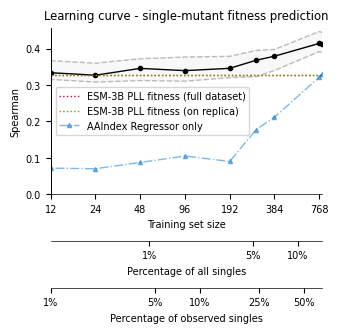

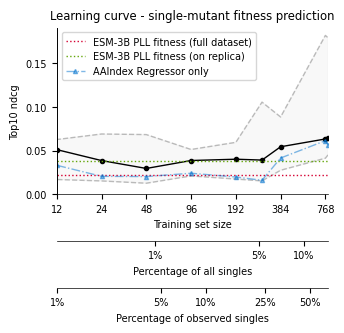

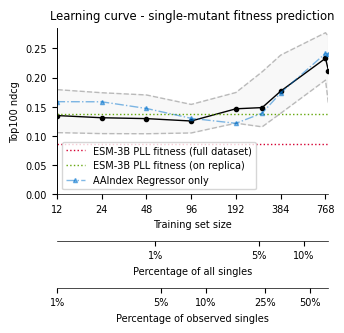

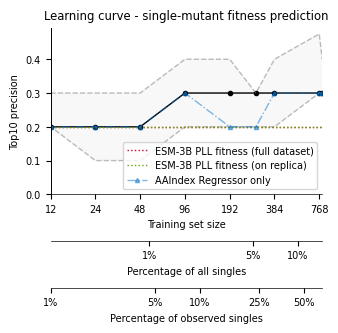

In [15]:
SAVE = True
SAVE_DIR = "./figures/single_mutant_model"
PERCENTAGES = [0.1, 1, 5, 10, 25, 50, 67]
WELL_PLATE_SIZES_TICKS = [12, 24, 48, 96, 2 * 96, 384, 2 * 384]

for metric in ["spearman", "top10_ndcg", "top100_ndcg", "top10_precision"]:
    # Extract the data for plotting
    keys = []
    medians, q25s, q75s = [], [], []
    for key, value in lc_output_lr_w_esm["result_stats"].items():
        keys.append(int(key))
        medians.append(value[metric]["med"])
        q25s.append(value[metric]["q25"])
        q75s.append(value[metric]["q75"])
    keys = np.array(keys)
    medians = np.array(medians)
    q25s = np.array(q25s)
    q75s = np.array(q75s)

    if keys[0] == 1:
        medians[0] = ESM_ZERO_SHOT[metric]
        q25s[0] = ESM_ZERO_SHOT[metric]
        q75s[0] = ESM_ZERO_SHOT[metric]

    keys_lr_only = []
    medians_lr_only, q25s_lr_only, q75s_lr_only = [], [], []
    for key, value in lc_output_lr["result_stats"].items():
        keys_lr_only.append(int(key))
        medians_lr_only.append(value[metric]["med"])
        q25s_lr_only.append(value[metric]["q25"])
        q75s_lr_only.append(value[metric]["q75"])
    keys_lr_only = np.array(keys_lr_only)
    medians_lr_only = np.array(medians_lr_only)
    q25s_lr_only = np.array(q25s_lr_only)
    q75s_lr_only = np.array(q75s_lr_only)

    # Plot learning curves
    # 1 column figure
    with plt.style.context(["nature"]):
        fig, ax = plt.subplots(figsize=get_dim(width=WIDTH.nature_column))

        # Special case for ESM
        ax.plot(keys, medians, "ko-")
        # ax.errorbar(keys, medians, yerr=[medians-q25s, q75s-medians], fmt="none", ecolor="k")
        ax.semilogx()
        ax.fill_between(keys, q25s, q75s, alpha=0.05, color="gray")
        ax.plot(keys, q25s, color="gray", alpha=0.5, linestyle="--")
        ax.plot(keys, q75s, color="gray", alpha=0.5, linestyle="--")
        ax.set_xlabel("Training set size")
        # Remove old ticks
        ax.set_xticks([], minor=True)
        # Set new ticks
        ax.set_xticks(WELL_PLATE_SIZES_TICKS, minor=False)
        ax.set_xticklabels(WELL_PLATE_SIZES_TICKS, rotation=-00)
        ax.set_ylabel(metric.capitalize().replace("_", " "))
        ax.set_ylim(0, None)
        ax.set_xlim(WELL_PLATE_SIZES_TICKS[0], keys[-1])

        # Add ESM zero-shot performance on entire dataset
        ax.axhline(
            ESM_ZERO_SHOT[metric],
            color=cambridge_core[0],
            linestyle="dotted",
            alpha=1,
            label="ESM-3B PLL fitness (full dataset)",
        )
        ax.axhline(
            esm_performances["result_stats"][str(WELL_PLATE_SIZES[0])][metric]["med"],
            color=cambridge_core[3],
            linestyle="dotted",
            label="ESM-3B PLL fitness (on replica)",
        )

        # Add LR only
        ax.plot(
            keys_lr_only,
            medians_lr_only,
            color=cambridge_core[1],
            linestyle="dashdot",
            marker="^",
            alpha=0.5,
            label="AAIndex Regressor only",
        )

        # Legend
        ax.legend(loc="best")

        # Show percentage of all singles on secondary x-axis
        # Calculate the positions for the secondary axis ticks (10%, 25%, 50% of the primary axis range)
        secondary_ticks = np.array(PERCENTAGES) * len(singles) / 100.0

        # Duplicate x-axis for % of dataset
        ax2 = ax.twiny()
        ax2.semilogx()
        # Remove old ticks
        ax2.set_xticks([], minor=True)
        ax2.set_xticks(secondary_ticks, minor=False)
        ax2.set_xticklabels([f"{p}%" for p in PERCENTAGES])
        ax2.set_xlabel("Percentage of all singles")

        # Adjust position of secondary x-axis
        ax2.xaxis.set_ticks_position("bottom")
        ax2.xaxis.set_label_position("bottom")
        ax2.spines["bottom"].set_position(("axes", -0.28))
        ax2.set_xlim(ax.get_xlim())

        # Show percentage of all observed data on tertiary x-axis
        # Calculate the positions for the secondary axis ticks (10%, 25%, 50% of the primary axis range)
        secondary_ticks = np.array(PERCENTAGES) * len(srired.data.query(train)) / 100.0
        ax3 = ax.twiny()
        ax3.semilogx()
        # Remove old ticks
        ax3.set_xticks([], minor=True)
        ax3.set_xticks(secondary_ticks, minor=False)
        ax3.set_xticklabels([f"{p}%" for p in PERCENTAGES])
        ax3.set_xlabel("Percentage of observed singles")

        # Adjust position of secondary x-axis
        ax3.xaxis.set_ticks_position("bottom")
        ax3.xaxis.set_label_position("bottom")
        ax3.spines["bottom"].set_position(("axes", -0.56))
        ax3.set_xlim(ax.get_xlim())

        sns.despine()
        plt.title("Learning curve - single-mutant fitness prediction")

    if SAVE:
        save_timestamped_figure(
            f"learning_curve_singles_{metric}_lr_w_esm_1col", save_dir=SAVE_DIR, file_types=["pdf"], date_format=""
        )
    plt.show()